In [1]:
# import sys
# sys.path.insert(0,'/home/idnm/Programming projects/jax_circuits')
from jax_circuits import *
from topology import *
from qiskit import QuantumCircuit
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from exact_decompositions import check_approximation

# Assembling

In [80]:
qc = QuantumCircuit(5)
qc.append(RXGate(jnp.pi).control(4), range(5))
qc.append(SGate().control(3), range(4))
print(disc2(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw()

0.0


q_0: ────■──────■──
         │      │  
q_1: ────■──────■──
         │      │  
q_2: ────■──────■──
         │    ┌─┴─┐
q_3: ────■────┤ S ├
     ┌───┴───┐└───┘
q_4: ┤ Rx(π) ├─────
     └───────┘

## Toffoli 5 without ancilla

We can find decomposition of Toffoli 5 without ancilla qubits using the following representation.

True


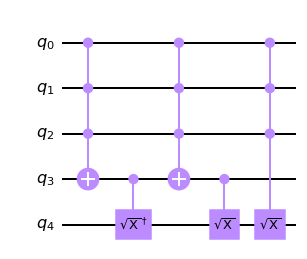

In [44]:
qc = QuantumCircuit(5)
qc.mct([0,1,2], 3)
qc.append(SXGate().inverse().control(1), [3,4])
qc.mct([0,1,2], 3)
qc.append(SXGate().control(1), [3,4])
qc.append(SXGate().control(3), [0,1,2,4])
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw(output='mpl')

In place of Toffoli 4 gates proper one can use relative phase Toffoli gates (On a fully connected topology they only 6 CNOT gates. I was not able to imporove this result allowing for an arbitrary 3-qubit unitary on control qubits. Note that if the unitary touches the target the result can be further improved to 4 CNOT gates). 

1.2942249e-31


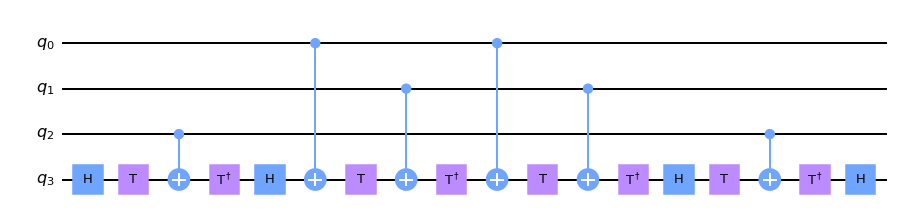

In [52]:
qc = QuantumCircuit(4)

qc.h(3)
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.h(3)
qc.cx(0, 3)
qc.t(3)
qc.cx(1, 3)
qc.tdg(3)
qc.cx(0, 3)
qc.t(3)
qc.cx(1, 3)
qc.tdg(3)
qc.h(3)
qc.t(3)
qc.cx(2,3)
qc.tdg(3)
qc.h(3)

u_toff4_relative = Operator(qc.reverse_bits()).data
print(disc_modulo_diagonal(u_toff4, u_toff4_relative, 4, [0, 1, 2, 3]))
qc.draw(output='mpl')

It remains to find an efficient decomposition of the controlled $\sqrt{X}$ gate. This is where we use our program -- it was able to find a 14-CNOT decomposition of the controlled $\sqrt{X}$ gate, the same complexity as the controlled $X$ itself. This gives in total 6+2+6+2+14=30 CNOT gates. The best 5-qubit Toffoli without ancilla decomposition known to me requires 36 CNOT gates.

# Decomposing

## Relative Toff 3

In [2]:
unitary_loss_f = lambda u: disc_modulo_diagonal(u_toff3, u, 3, [2])
decomposer = Decompose(connected_layer(3), unitary_loss_func=unitary_loss_f, label='relative_toff3_2q')
options = StaticOptions(num_cp_gates=8, accepted_num_cz_gates=4, num_samples=15)

results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=15, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, num_cp_gates=8, r=0.00055, accepted_num_cz_gates=4)

Computing raw results...

Selecting prospective results...

Found 2. Verifying...


  0%|          | 0/2 [00:00<?, ?it/s]


2 successful. cz counts are:
[4, 4]


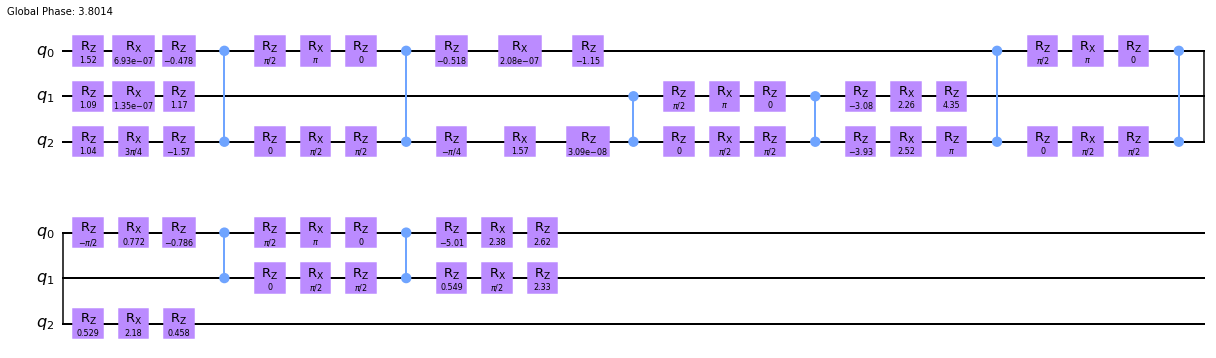

In [3]:
qc = results.decompositions[-1].circuit
qc.draw(output='mpl')

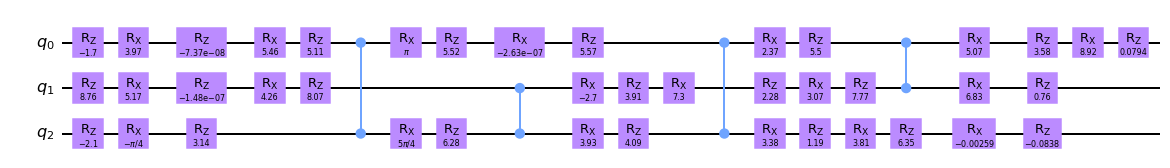

In [7]:
qc_cz = cp_to_cz_circuit(qc, cp_threshold=1e-6)
qc_cz.draw(output='mpl')

Difference 0.18543720245361328 between modified and original circuit is above threshold 1e-05.


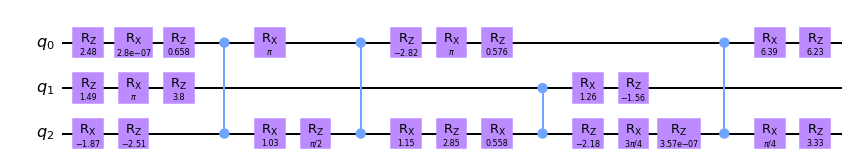

In [14]:
d = results.decompositions[0]
d.make_exact(recursion_degree=2)
d.circuit.draw(output='mpl')

In [21]:
d._decomposer
d._static_options

reproducible_results = d._decomposer.static(d._static_options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=20, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, num_cp_gates=8, r=0.00055, accepted_num_cz_gates=4)

Computing raw results...

Selecting prospective results...

Found 4. Verifying...


  0%|          | 0/4 [00:00<?, ?it/s]


4 successful. cz counts are:
[4, 4, 4, 4]


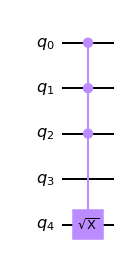

In [28]:
qc = QuantumCircuit(5)
qc.append(SXGate().control(3), [0,1,2,4])
u_sqrt = Operator(qc.reverse_bits()).data
qc.draw(output='mpl')

In [69]:
def singeq_to_U(gate):
    qc = QuantumCircuit(1)
    qc.append(gate, [0])
    
    qc = transpile(qc, basis_gates=['u'])

    return qc.to_gate(label='uu')


def convert_to_U(circuit):
    qc = circuit.copy()
    new_data = []
    for gate, qargs, cargs in qc.data:
        if len(qargs)==1:
            new_gate = singeq_to_U(gate)
        else:
            new_gate = gate
        new_data.append((new_gate, qargs, cargs))

    qc.data = new_data
    qc = qc.decompose('uu')
    
    pass_ = Optimize1qGates(basis=['u'])
    pm = PassManager(pass_)
    qc = pm.run(qc)
    
    check_approximation(circuit, qc)
    return qc

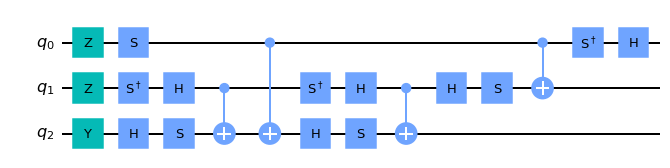

In [70]:
qc = QuantumCircuit(3)
qc.append(random_clifford(3, seed=0), [0,1,2])
u_target = Operator(qc.reverse_bits()).data
qc = qc.decompose()
qc.draw(output='mpl')

In [80]:
results.decompositions

[< toff4_sqrt_chain| Approximate | cz count: 0 | cz depth: 0 | loss: 1.1920928955078125e-06 >,
 < toff4_sqrt_chain| Approximate | cz count: 0 | cz depth: 0 | loss: 3.4570693969726562e-06 >,
 < toff4_sqrt_chain| Approximate | cz count: 0 | cz depth: 0 | loss: 2.384185791015625e-07 >]

In [81]:
results = Results.load('results/toff4_sqrt_chain')
d = results.decompositions[-2]
qc = d.circuit
# qc.draw(output='mpl')

In [84]:
qc_cz = cp_to_cz_circuit(qc, cp_threshold=0.01)
cost_HST(Operator(qc_cz.reverse_bits()).data, Operator(qc.reverse_bits()).data)

DeviceArray(1.1920929e-07, dtype=float32)

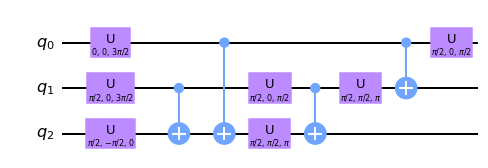

In [71]:
qc_u = convert_to_U(qc)
qc_u.draw(output='mpl')

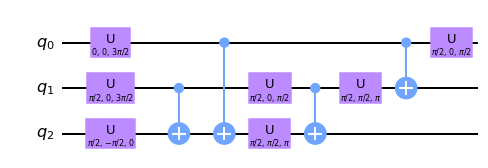

In [59]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager


from qiskit.transpiler.passes import Optimize1qGates


In [44]:
qc = QuantumCircuit(5)
qc.mct([0,1,2,3], 4)
layer = connected_layer(5)
cmap = layer+[[q2, q1] for q1,q2 in layer]
qc_trans1 = transpile(qc, basis_gates = ['u', 'cz'], coupling_map=cmap, optimization_level=3)
qc_trans2 = transpile(qc, basis_gates = ['rz', 'rx', 'cz'], coupling_map=cmap, optimization_level=0)
print(cost_HST(Operator(qc_trans1).data, Operator(qc_trans2).data))
# qc_trans.draw()

0.0


## Controlled RZ

It appears that on a chain topology 7 is the minimum number of CZ to decompose controlled $RZ(\pi)$.

In [21]:
qc = QuantumCircuit(3)
qc.append(RZGate(jnp.pi).control(2), [0, 1, 2])
# qc.append(SGate().control(1), [0,1])
u_crz = Operator(qc.reverse_bits()).data


layer = chain_layer(3)
decomposer = Decompose(layer, target_unitary=u_crz, label='crz3')
adaptive_options = AdaptiveOptions(min_num_cp_gates=2, max_num_cp_gates=12)

results = decomposer.adaptive(adaptive_options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=100, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, min_num_cp_gates=2, max_num_cp_gates=12, r_mean=0.00055, r_variance=0.5, max_evals=100, target_num_cz_gates=0, stop_if_target_reached=False, random_seed=0)


Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]


------------------------------------------

num_cp_gates: 6, r: 0.0005576462703701775
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 6, r: 0.0004645703038510526
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 6, r: 0.0006478863656424135
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 3, r: 0.002117336240028973
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 11, r: 0.0009698647172215286
score: 7.229204177856445, cz counts of prospective results: [7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 12]

Found 21 decompositions potentially improving the current best count 14, verifying...

Found a new decomposit

KeyboardInterrupt: 

Let's see if we can do better up to 2q unitary.

In [24]:
qc = QuantumCircuit(3)
qc.append(RZGate(jnp.pi).control(2), [0, 1, 2])
u_crz = Operator(qc.reverse_bits()).data

layer = chain_layer(3)
unitary_loss_func = lambda u: disc_modulo_identity(u_crz, u, 3, [2])
decomposer = Decompose(layer, unitary_loss_func=unitary_loss_func, label='crz3_2q')
adaptive_options = AdaptiveOptions(min_num_cp_gates=2, max_num_cp_gates=12)

results = decomposer.adaptive(adaptive_options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=100, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, min_num_cp_gates=2, max_num_cp_gates=12, r_mean=0.00055, r_variance=0.5, max_evals=100, target_num_cz_gates=0, stop_if_target_reached=False, random_seed=0)


Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]


------------------------------------------

num_cp_gates: 6, r: 0.0005576462703701775
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 6, r: 0.0004645703038510526
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 6, r: 0.0006478863656424135
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 3, r: 0.002117336240028973
score: inf, cz counts of prospective results: []

Found no better decompositions.

------------------------------------------

num_cp_gates: 11, r: 0.0009698647172215286
score: 6.312576770782471, cz counts of prospective results: [6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 14]

Found 49 de

KeyboardInterrupt: 

In [54]:
def extract_from_kronecker_product_with_identity(m):
    a = m[::2, ::2]
    assert jnp.allclose(jnp.kron(a, jnp.identity(2)), m, rtol=1e-5, atol=1e-4) , 'Input matrix is not a kronecker product with identity.'
    return a


Starting decomposition routine with the following options:

 StaticOptions(num_samples=200, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=0.0001, threshold_cp=0.05, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, num_cp_gates=6, r=0.00055, accepted_num_cz_gates=2)

Computing raw results...

Selecting prospective results...

Found 25. Verifying...


  0%|          | 0/25 [00:00<?, ?it/s]


25 successful. cz counts are:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


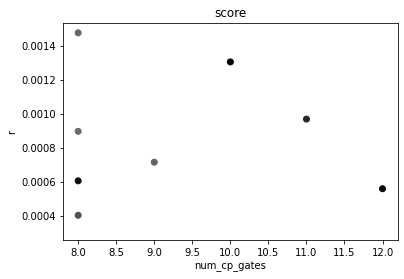

In [71]:
results = Results.load('results/crz3_2q')
results.plot_trials()
d_crz_2q = results.decompositions[0]
u2q =  d_crz_2q.unitary_func(d_crz_2q.angles) @ u_crz.conj().T
u2q = extract_from_kronecker_product_with_identity(u2q)

qc = QuantumCircuit(2)
qc.append(SGate().control(1), (0,1))
u_cs = Operator(qc.reverse_bits()).data

layer = [[0,1]]
u_target = u2q.conj().T #  u_cs @
decomposer = Decompose(layer, target_unitary=u_target, label='cs_2q')
static_options = StaticOptions(num_cp_gates=6, accepted_num_cz_gates=2, num_samples=200, threshold_cp=0.05, entry_loss=1e-3, target_loss=1e-4)

results = decomposer.static(static_options)

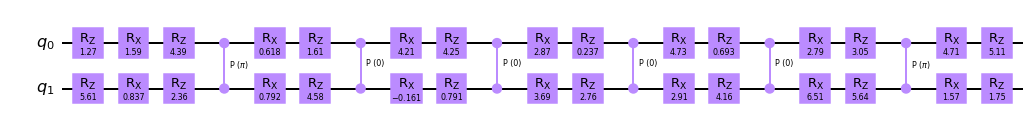

In [75]:
results.decompositions[0].circuit.draw(output='mpl')